In [37]:
import re
from difflib import SequenceMatcher  #used to copare two sequences

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix  #Compressed Sparse Row. The sparse matrix is represente
#using three one-dimensional arrays for the non-zero values, the extents of the rows, and the column indexes.

from sklearn.neighbors import NearestNeighbors

In [38]:
movies = pd.read_csv('data/movies.csv')
movies = movies.drop(['genres'],axis='columns')


In [39]:
ratings = pd.read_csv('data/ratings.csv')
ratings = ratings.drop(['timestamp'],axis='columns')

In [40]:
movies.head() #usd to show tble

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [41]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [42]:
ratings['rating'].sort_values().unique() #sorts ratngs clms which have unique values

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [43]:
movies.values.shape[0]  #rtens nof rows of data 

9742

In [44]:
ratings.values.shape[0]

100836

In [45]:
ratings['userId'].nunique() #return n unique vakues

610

In [46]:
popular_movies_thresh =25
active_users_thresh = 100


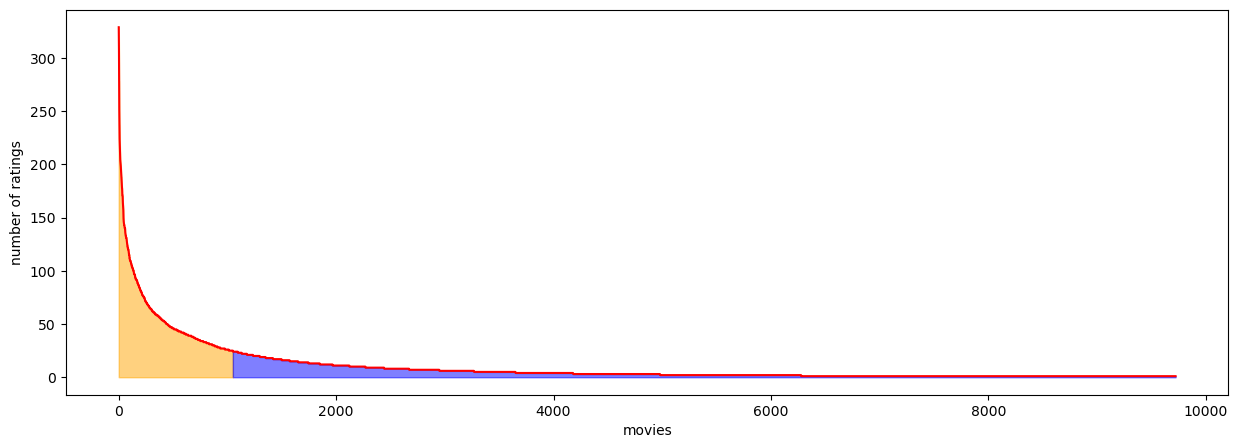

In [47]:
movies_count = pd.DataFrame(ratings.groupby('movieId').size().sort_values(ascending =False), columns=['count'])
divider=len(movies_count.query('count >=@popular_movies_thresh'))
fig, (ax) =plt.subplots(1,1,figsize=(15,5))
plt.plot(np.arange(len(movies_count)),movies_count['count'],color='red')
plt.xlabel('movies')
plt.ylabel('number of ratings')

ax.fill_between(np.arange(0,divider),
                0,
                movies_count['count'][:divider],
                color='orange', 
                alpha=0.5)

ax.fill_between(np.arange(divider,len(movies_count)),
                0,
                movies_count['count'][divider:],
                color='blue', 
                alpha=0.5)


In [48]:
#discarding the unpopular movies 

popular_movies_indices= movies_count.query('count >=@popular_movies_thresh').index #stores all the index of movies over the threshold
popular_ratings =ratings[ratings['movieId'].isin(popular_movies_indices)] # using indeces of popular movies we select rating using isin function

In [49]:
ratings.shape[0]

100836

In [50]:
popular_ratings.shape[0]

62518

In [51]:
# no.of movie before removing unpopular movie
ratings.groupby('movieId').count().shape[0]



9724

In [52]:
#no.of movies after dropping unpopular movies
popular_ratings.groupby('movieId').count().shape[0]

1050

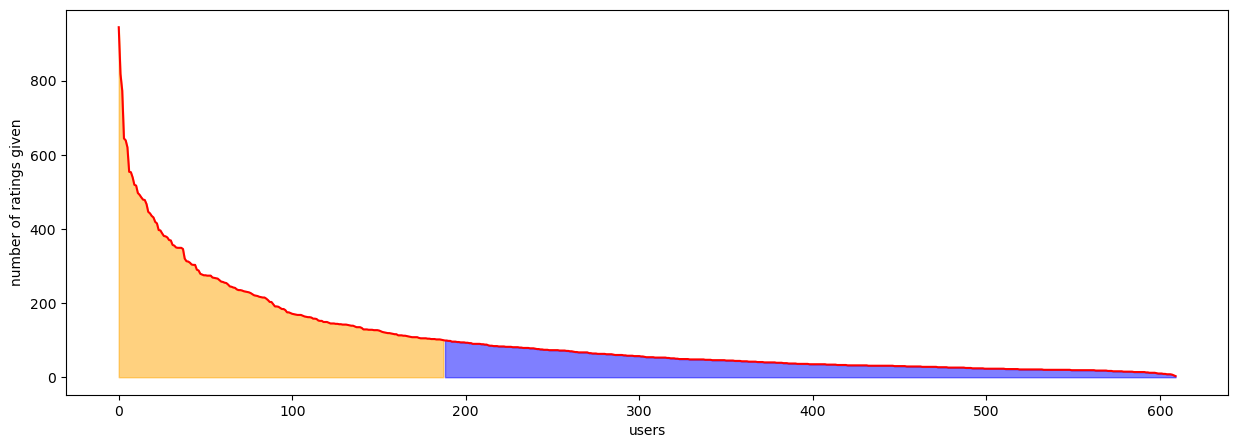

In [53]:
#visualizing longtail for active users
#after plotting this graph we get the indices of all the users
users_count= pd.DataFrame(popular_ratings.groupby('userId').size().sort_values(ascending=False) ,columns=['count'])
divider= len(users_count.query('count >=@active_users_thresh'))

fig, (ax) =plt.subplots(1,1,figsize=(15,5))
plt.plot(np.arange(len(users_count)),users_count['count'],color='red')
plt.xlabel('users')
plt.ylabel('number of ratings given')

ax.fill_between(np.arange(divider),
                0,
                users_count['count'][:divider],
                color='orange', 
                alpha=0.5)

ax.fill_between(np.arange(divider,len(users_count)),
                0,
                users_count['count'][divider:],
                color='blue', 
                alpha=0.5)


In [54]:
#removing non active users from the data frame
#we select active users from data frame using isin function

active_users_indices = users_count.query('count >=@active_users_thresh').index
active_users_ratings= popular_ratings[popular_ratings['userId'].isin(active_users_indices)]


In [55]:
#no of rows in ratings data after removing unpopular movies 
popular_ratings.shape[0]

62518

In [56]:
#no of rows in ratings data after removing unpopularr and inactive users

active_users_ratings.shape[0]

44588

In [57]:
#number of users in data before removing inactive users
popular_ratings.groupby('userId').count().shape[0]

610

In [58]:
##number of users in data after removing inactive users
active_users_ratings.groupby('userId').count().shape[0]

188

In [59]:
#creating pivot able and sparse matrix
#crating pivot table with rows cotaining movieid and coloumns containning userid
#the cell containg rating given y the user to a movie
#fiilna fills missing data with o's


pivot_table =active_users_ratings.pivot(index='movieId' ,columns='userId' ,values='rating').fillna(0)

In [60]:
#no of movie in pivot table 
#retuns no of rows in the table
pivot_table.index.shape[0]

1050

In [61]:
#no of users in ivot table

pivot_table.columns.shape[0]

188

In [62]:
pivot_table.head()

userId,1,4,6,7,15,18,19,20,21,22,...,597,599,600,602,603,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,2.5,3.5,4.0,0.0,3.5,0.0,...,4.0,3.0,2.5,0.0,4.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,...,0.0,2.5,4.0,4.0,0.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,3.0,4.5,0.0,3.0,4.0,0.0,0.0,0.0,0.0,5.0


In [63]:
#this containg so many o's due to long tail
#if we use this directly to knn it'll be slow
#so we need to compress the table into sparse matrix using csr_matrix function 
#entir row is considered as feature

sparse_matrix = csr_matrix(pivot_table.values)

In [64]:
#mapping from movie id to movie title and vicecersa
#we need titles and id's from movies data frame
#we set index of movie dataframe to moveid so using loc function we can select any row by selcting movie id from pivot table


pivot_table_movies = movies.set_index('movieId').loc[pivot_table.index]['title'].values
title_to_id ={movie :i for i ,movie in enumerate(pivot_table_movies)}


In [65]:
id_to_title ={v : k for k,v in title_to_id.items()}

In [66]:
#kNN
model_knn = NearestNeighbors(metric='cosine' , algorithm='brute')
model_knn.fit(sparse_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [67]:
#title_to_id is mapping that we created
#movie_title is keyword to be serched for
def find_matches(title_to_id,movie_title):
    movies_ids = np.array(list(title_to_id.values())).astype(int) #creates array 
    titles = np.array(list(title_to_id.keys()))
    ratios=list()
    for title, movie_id in title_to_id.items():
        ratio=SequenceMatcher(None, movie_title, title, autojunk=False).ratio()
        ratios.append(ratio)
    titles,ids =titles[np.argsort(ratios)][-10:], movies_ids[np.argsort(ratios)][-10:]  
    return list(reversed(list(zip(titles,ids))))

In [68]:
title ='watchmen'
options=find_matches(title_to_id,title)

import ipywidgets as widgets
drop =widgets.Dropdown(options=options)
drop

Dropdown(options=(('Watchmen (2009)', 941), ('Matchstick Men (2003)', 788), ('Patch Adams (1998)', 497), ('Bat…

In [34]:
movies_id =drop.value
test=pivot_table.iloc[movies_id, :].values.reshape(1, -1)

distances, indices = model_knn.kneighbors(test, n_neighbors=10 + 1)

indices=indices.squeeze()[1:]

print(' Recommendations For : ' ,id_to_title[movies_id])
for i, index in enumerate(indices):
    print(i+1, '.', id_to_title[index])

 Recommendations For :  Watchmen (2009)
1 . Iron Man (2008)
2 . Kick-Ass (2010)
3 . District 9 (2009)
4 . Inception (2010)
5 . Source Code (2011)
6 . Black Swan (2010)
7 . Dark Knight, The (2008)
8 . X-Men Origins: Wolverine (2009)
9 . Thor (2011)
10 . Incredible Hulk, The (2008)


In [1]:
import re
from difflib import SequenceMatcher
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets

# Load movie and ratings data
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')

# Preprocessing
movies = movies.drop(['genres'], axis='columns')
ratings = ratings.drop(['timestamp'], axis='columns')

# Filter unpopular movies and inactive users
popular_movies_thresh = 25
active_users_thresh = 100

movies_count = ratings['movieId'].value_counts()
popular_movies_indices = movies_count[movies_count >= popular_movies_thresh].index
popular_ratings = ratings[ratings['movieId'].isin(popular_movies_indices)]

users_count = popular_ratings['userId'].value_counts()
active_users_indices = users_count[users_count >= active_users_thresh].index
active_users_ratings = popular_ratings[popular_ratings['userId'].isin(active_users_indices)]

# Create pivot table and sparse matrix
pivot_table = active_users_ratings.pivot(index='movieId', columns='userId', values='rating').fillna(0)
sparse_matrix = csr_matrix(pivot_table.values)

# Model Training
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(sparse_matrix)

# Function to find movie matches using fuzzy string matching
def find_matches(title_to_id, movie_title):
    ratios = [SequenceMatcher(None, movie_title, title, autojunk=False).ratio() for title in title_to_id.keys()]
    sorted_titles = [title for _, title in sorted(zip(ratios, title_to_id.keys()), reverse=True)]
    sorted_ids = [title_to_id[title] for title in sorted_titles]
    return list(zip(sorted_titles[:10], sorted_ids[:10]))

# Dynamic updating function
def update_model(new_ratings):
    # Add new ratings to the ratings DataFrame
    global ratings
    ratings = pd.concat([ratings, new_ratings], ignore_index=True)
    
    # Filter unpopular movies and inactive users
    popular_movies_indices = ratings['movieId'].value_counts()[ratings['movieId'].value_counts() >= popular_movies_thresh].index
    popular_ratings = ratings[ratings['movieId'].isin(popular_movies_indices)]
    users_count = popular_ratings['userId'].value_counts()
    active_users_indices = users_count[users_count >= active_users_thresh].index
    active_users_ratings = popular_ratings[popular_ratings['userId'].isin(active_users_indices)]
    
    # Update pivot table and sparse matrix
    pivot_table = active_users_ratings.pivot(index='movieId', columns='userId', values='rating').fillna(0)
    global sparse_matrix
    sparse_matrix = csr_matrix(pivot_table.values)
    
    # Retrain the model
    model_knn.fit(sparse_matrix)

# Function to recommend movies based on user input
def recommend_movies(movie_title):
    options = find_matches(title_to_id, movie_title)
    dropdown = widgets.Dropdown(options=options, description='Select a movie:')
    display(dropdown)
    
    def on_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            movie_id = change['new']
            test = pivot_table.iloc[movie_id, :].values.reshape(1, -1)
            distances, indices = model_knn.kneighbors(test, n_neighbors=10 + 1)
            indices = indices.squeeze()[1:]
            print('Recommendations for:', id_to_title[movie_id])
            for i, index in enumerate(indices):
                print(i + 1, '.', id_to_title[index])
    
    dropdown.observe(on_change)
    
# Load movie titles and create mappings
pivot_table_movies = movies.set_index('movieId').loc[pivot_table.index]['title'].values
title_to_id = {movie: i for i, movie in enumerate(pivot_table_movies)}
id_to_title = {v: k for k, v in title_to_id.items()}

# Example of recommending movies based on user input
recommend_movies('watchmen')

# Example of dynamic updating with new ratings
new_ratings = pd.DataFrame({'userId': [999, 999, 999],
                             'movieId': [1, 2, 3],
                             'rating': [5, 4, 3]})
update_model(new_ratings)


Dropdown(description='Select a movie:', options=(('Watchmen (2009)', 941), ('Matchstick Men (2003)', 788), ('P…

Recommendations for: Snatch (2000)
1 . Fight Club (1999)
2 . American History X (1998)
3 . Lock, Stock & Two Smoking Barrels (1998)
4 . Big Lebowski, The (1998)
5 . Lord of the Rings: The Fellowship of the Ring, The (2001)
6 . Lord of the Rings: The Return of the King, The (2003)
7 . Seven (a.k.a. Se7en) (1995)
8 . Matrix, The (1999)
9 . Gladiator (2000)
10 . Lord of the Rings: The Two Towers, The (2002)
Recommendations for: Batman Returns (1992)
1 . Batman & Robin (1997)
2 . Batman Forever (1995)
3 . Batman (1989)
4 . RoboCop (1987)
5 . Die Hard 2 (1990)
6 . Die Hard (1988)
7 . Highlander (1986)
8 . Mummy, The (1999)
9 . Con Air (1997)
10 . Superman (1978)
